In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost, relative_entropy_control_cost_direct
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Variance and Mean Matching bug Here

Check out ln_prior there I am tweaking $\sigma_w$ Ive set the log_likelihood to be 0 this way our algorithm should be trying to have as target the prior . For some reason the neural net is completely unable to match the variance I am specifying I have gone from very low to very high and the method is unable to do anhything to fit the target variance. For a sufficiently small $\Delta t$ we should be able to do this, standard VI is able to do this, so theres some sort of bug / issue here. 

UPDATE: Atm its not even matching the mean hardcoded it to 10 and nothings happening ?? whats going on here?

In [62]:
# TODO: Why is changing σ_w doing nothing ??
def ln_prior(Θ, σ_w=0.01):
    """
    Prior for means in Bayesian GMM
    """
    return -0.5 * ((Θ-10)**2).sum(axis=1) / σ_w

In [63]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim =  2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [64]:
relative_entropy_control_cost_direct(sde, Θ_0, ln_prior, γ=1.0, device=device)

tensor(10294.4482, device='cuda:0', grad_fn=<MeanBackward0>)

In [101]:
γ = 1
Δt=0.005
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.01, weight_decay =0.01)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 1000

train = True
if train:
    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                loss = relative_entropy_control_cost_direct(
                    sde, Θ_0.float(),
                    ln_prior, γ=γ
                )
                optimizer.zero_grad()
                loss.backward()
                return loss

            optimizer.step(closure)
            losses.append(closure().item())
        else:
            loss = relative_entropy_control_cost_direct(
                sde, Θ_0,
                ln_prior, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            losses.append(loss.item())

200


  0%|          | 0/1000 [00:00<?, ?it/s]

In [102]:
losses

[10099.287109375,
 10422.4130859375,
 10410.33984375,
 9976.787109375,
 9884.4033203125,
 9613.17578125,
 9037.576171875,
 8674.771484375,
 8635.8369140625,
 8121.365234375,
 7751.22119140625,
 7247.861328125,
 6558.72607421875,
 5952.17724609375,
 4583.40380859375,
 4039.530029296875,
 3329.40234375,
 4276.966796875,
 4050.115234375,
 3664.994384765625,
 3394.230224609375,
 2917.282958984375,
 3060.120849609375,
 2598.674560546875,
 2872.25341796875,
 2836.776123046875,
 2752.1474609375,
 2795.633056640625,
 2647.939697265625,
 2281.66796875,
 2309.81005859375,
 2447.2080078125,
 2451.711669921875,
 2427.260986328125,
 2384.87255859375,
 2349.253173828125,
 2187.2333984375,
 2217.73193359375,
 2129.31591796875,
 2273.785400390625,
 2196.460693359375,
 2143.3564453125,
 2182.3369140625,
 2121.648193359375,
 1986.2762451171875,
 2002.590087890625,
 1914.29638671875,
 1943.57373046875,
 1956.4371337890625,
 1931.5777587890625,
 1920.2418212890625,
 1941.1253662109375,
 1917.74560546875,


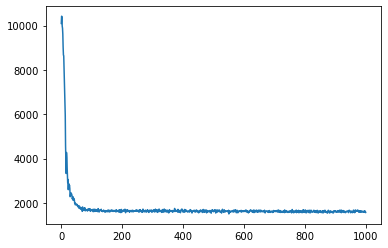

In [103]:
plt.plot(losses[:])

In [104]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([200, 50, 2])

In [105]:
# Mannualy doing one step of Euler

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

In [106]:
Θ_1 = Θ_1.reshape(50,2)

(array([ 4.,  3., 10.,  5., 11.,  6.,  5.,  3.,  2.,  1.]),
 array([7.34767  , 7.570112 , 7.7925544, 8.014997 , 8.237438 , 8.459881 ,
        8.6823225, 8.904765 , 9.127207 , 9.349649 , 9.572091 ],
       dtype=float32),
 <a list of 10 Patch objects>)

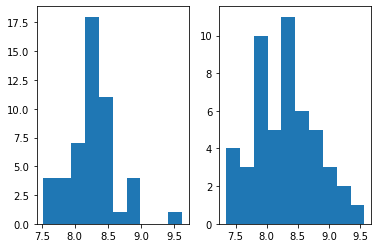

In [107]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,1].flatten().cpu().detach().numpy())

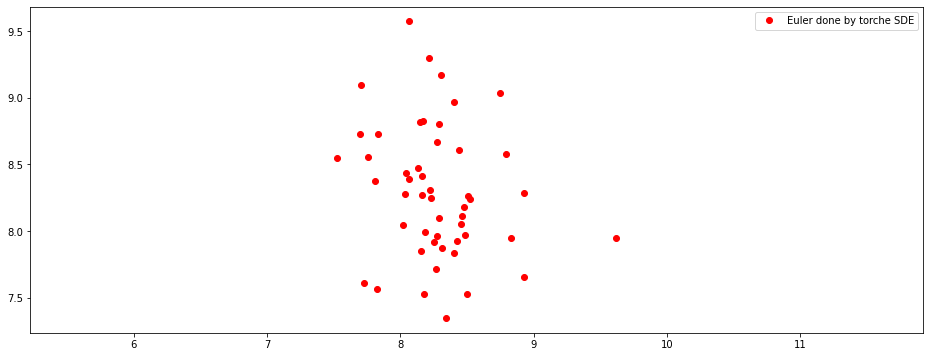

In [108]:
fig, ax_1 = plt.subplots(1, 1, figsize=(16, 6))
Θ_plot = Θ_1.cpu().detach() #.reshape(50*3,2)

# Θ_plot2 = Θ_2.cpu().detach() 



ax_1.plot(Θ_plot[:, 0], Θ_plot[:, 1], 
         linestyle='none', 
         marker='o', color="red", label="Euler done by torche SDE")

# ax_1.plot(Θ_plot2[:, 0], Θ_plot2[:, 1], 
#          linestyle='none', 
#          marker='o', color="blue", label="Euler done manually")

# ax_1.plot(X_scaled[:, 0], X_scaled[:, 1], 
#          linestyle='none', 
#          marker='o', label="Observations $X$")

ax_1.legend()
ax_1.axis('equal');